<a href="https://colab.research.google.com/github/babyraggge/time-data-prediction-methods/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Итоговое задание

*   Бельтюков Михаил
*   РИ-481223
*   Вариант 1

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [239]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA

from scipy import signal
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

from statsmodels.tsa import api as tsa

import h5py
import pywt

%matplotlib inline

Загрузим данные из файла и отобразим временной ряд на графике:

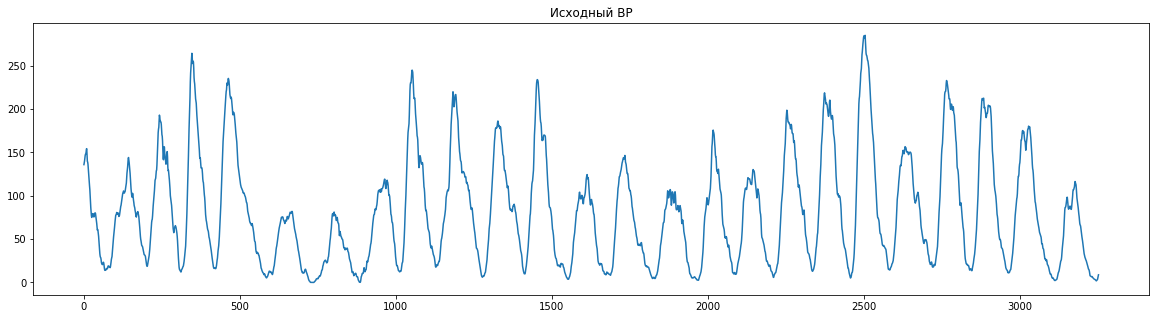

In [3]:
X = np.loadtxt('1.txt')
t = np.arange(X.shape[0])

plt.figure(figsize= (20, 5))
plt.plot(t, X)
plt.title('Исходный ВР')
plt.show()

Оценим мат. ожидание, дисперсию данных:

In [4]:
M = np.mean(X)
D = np.var(X)
print("Расчитанное мат. ожидание для ВР: ", M)
print("Расчитанная дисперсия для ВР: ", D)

Расчитанное мат. ожидание для ВР:  81.83621272671381
Расчитанная дисперсия для ВР:  4000.0259434801087


Прежде чем строить какие либо дальнейшие оценки, обратим внимание, все исходные оценки статистических свойств опираются на тот факт, что исследуемый ВР предполагаетсястационарным. Если ряд является нестационарным, то абсолютно все оценки, как автокорреляционные, так и спектральные, теряют свой смысл. Поэтому в первую очередь проверим ряд на стационарность при помощи статистических тестов.

Произведем оценку ВР на стационарность, используя KPSS-тест. В качестве нулевой гипотизы соответственно рассматирвам стационарность данного ряда.

In [5]:
def kpss_test(timeseries):
    print ('Результаты KPSS теста:')
    kpsstest = tsa.kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Статистика Теста','p-value','Число лагов'])
    for key,value in kpsstest[3].items():
        kpss_output['Критическое Значение (%s)'%key] = value
    print(kpss_output)

In [6]:
kpss_test(X)

Результаты KPSS теста:
Статистика Теста                0.126331
p-value                         0.100000
Число лагов                    29.000000
Критическое Значение (10%)      0.347000
Критическое Значение (5%)       0.463000
Критическое Значение (2.5%)     0.574000
Критическое Значение (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Анализируя статистику KPSS теста (близко к 0), и p значение (больше 0.05) с достаточной долей уверенности нулевая гипотиза не отвергается. Ряд является стационарным.

Так же проверем с помощью однофакторного дисперсионного анализа две половинки(по времени) исходного временного рядана соответствие дисперсий, чтобы убедиться, что это частные выборки одной и той же случайной величины:

In [7]:
N = round(len(X)/2)
F, p_value = stats.f_oneway(X[:N], X[N:])
print(f" F статистика теста: {F}\n p-value: {p_value}")

 F статистика теста: 0.8034589634236382
 p-value: 0.3701275712387072


Значение p-value говорит о том, что нет достаточных оснований полагать, что данные выборки отностятся к разным случайным величинам. Нулевая гипотиза о равенстве дисперсий не отвергается.

Проверем с помощью критерия Стьюдента две половинки исходного временного ряда на соответствие мат. ожиданий при предположении о равных дисперсиях:

In [8]:
T, p_value = stats.ttest_ind(X[:N], X[N:])
print(f" T статистика теста: {T}\n p-value: {p_value}")

 T статистика теста: -0.8963587247434098
 p-value: 0.3701275712368498


Гипотиза о равенстве мат. ожиданий не отвергается.

Теперь имеет смысл рассматривать периодограмму и спектрограмму выбранного ряда. Сначала строим периодограмму.

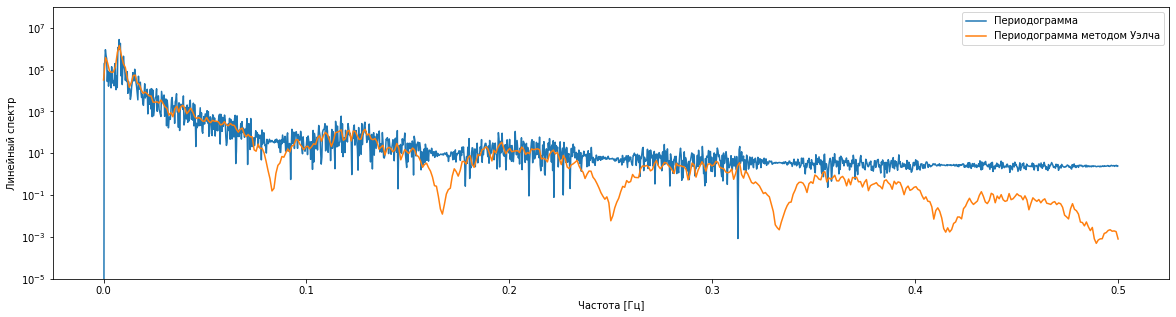

In [9]:
pd1, pdden1 = signal.periodogram(X)
pdw1, pddenw1 = signal.welch(X, nperseg = 1024)


plt.figure(figsize = (20, 5))
plt.semilogy(pd1, pdden1, label='Периодограмма')
plt.semilogy(pdw1, pddenw1, label='Периодограмма методом Уэлча')
plt.ylim(1e-5)
plt.xlabel('Частота [Гц]')
plt.ylabel('Линейный спектр')
plt.legend();

Анализируя полученную оценку спектральной мощности выборки методом Уэлча, можно заметить некоторое понижение мощности на следующих частотах:

In [10]:
from operator import itemgetter
print(pdw1[[min(enumerate(pddenw1[0+window*100:100+window*100]), key=itemgetter(1))[0]+window*100 
            for window in range(5)]])
# Cложно получилось, но выводит то, что нужно

[0.08300781 0.16699219 0.25       0.33300781 0.41503906]


Из спектрограммы видно, что нет зависимоси частоты от времени для данного ВР.

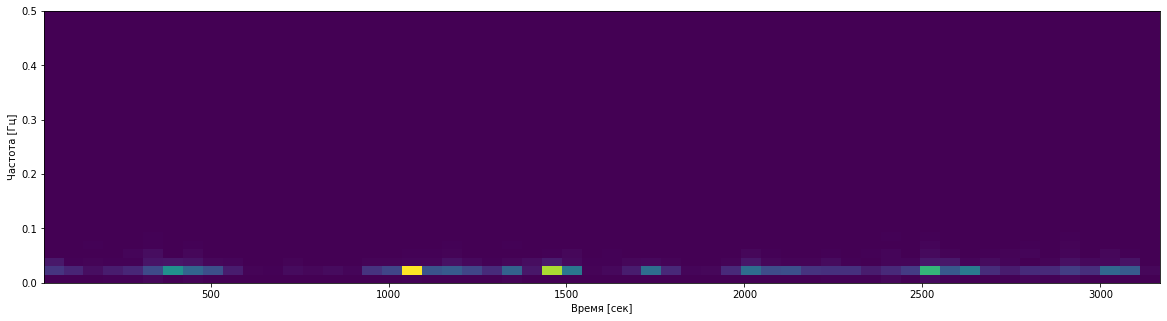

In [11]:
f, tx, Sxx= signal.spectrogram(X, nperseg=64, noverlap=8, nfft=64) # возвращаем частоту от времени

plt.figure(figsize= (20, 5))
plt.pcolormesh(tx, f, Sxx) # цвет – интенсивность спектрограммы
plt.ylabel('Частота [Гц]') #строим до 150 Гц, иначе будет до fs/2
plt.xlabel('Время [сек]')
plt.show()

In [12]:
def make_hilbert(w, tx, figsize=(20, 5)):
  fs = 1/(tx[1]-tx[0])
  analytic_signal = signal.hilbert(w) # аналитический сигнал
  instantaneous_phase = np.unwrap(np.angle(analytic_signal)) # мгновенная фаза в развернутом непрерывном виде
  instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) # мгновенная частота как производная от фазы, приведенная в Гц

  plt.figure(figsize=figsize)
  # из-за численного расчета производной массив мгновенной частоты будет меньше массива времени на одну точку:
  plt.plot(tx[1:], instantaneous_frequency)
  plt.title('Преобразование Гильберта')
  plt.ylabel('Частота [Гц]')
  plt.xlabel('Время [сек]')
  plt.show()

Так же, чтобы еще раз убедиться в отсуствствии зависимомти, выполним преобразование Гильберта и построим соответсвтующий график:

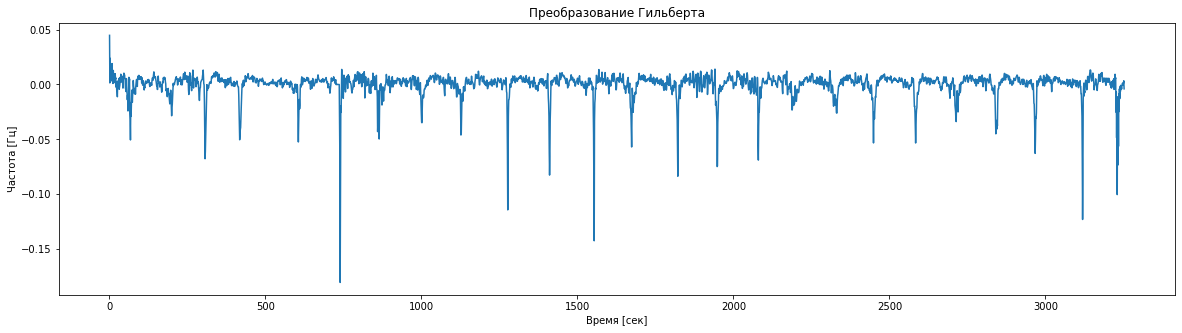

In [13]:
make_hilbert(X, t)

Построим регрессионные модели тренда первого порядка и третьего порядка. На графике видно, что ряд не является монотонным. Построим тренд для данных.

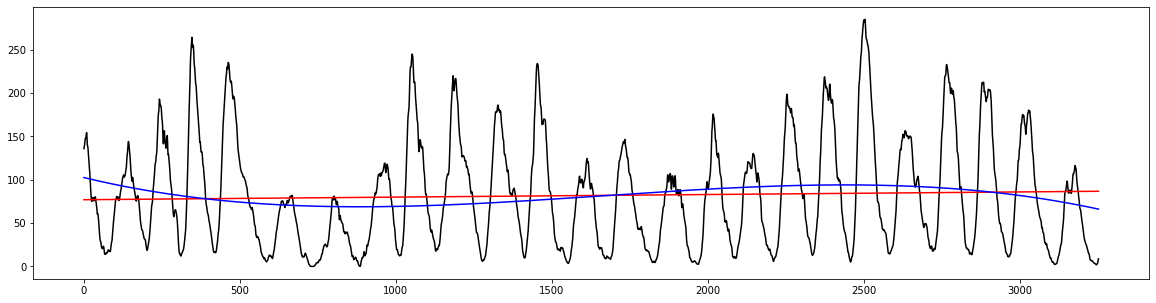

In [16]:
popt, pcov = curve_fit(lambda t, b0, b1: b0 + b1 * t, 
                       t, X)

popt3, pcov3 = curve_fit(lambda t, b0, b1, b2, b3: b0 + b1 * t + b2 *t * t + b3 *t *t *t, 
                         t, X)

plt.figure(figsize = (20, 5))
plt.plot(t, X, 'k')
plt.plot(t, t*popt[1]+popt[0], 'r')
plt.plot(t, t*t*t*popt3[3]+t*t*popt3[2]+t*popt3[1]+popt3[0], 'b')
plt.show()

Прогноз будем делать на 650 точек вперед

In [17]:
pred_size = 650
X_part = X[:len(X)-pred_size+1] # отрезаем последние 650 точек
t_part = np.arange(len(X_part)) # временная шкала для регрессии

Подберем параметрическую кривую, которая давала бы более высокую точность, нежели простые линейные регрессионные кривые. В качестве такой кривой выбираем синусоиду c периодом колбений 1200 единиц времени.

In [19]:
def delta23(pred, real):
  return 1.96 * np.sqrt(np.sum((pred-real)**2)/real.shape[0])

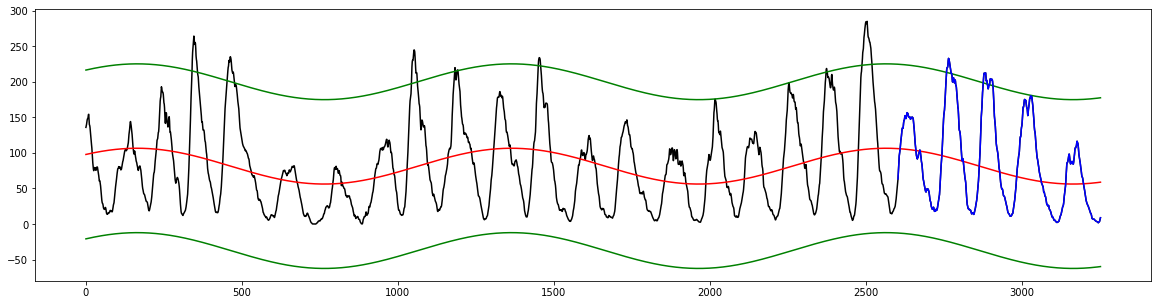

In [186]:
def func(t, a, b, c):
  return a + b*np.sin(np.pi/600*t + c)

popt, pcov = curve_fit(func, t, X)

plt.figure(figsize = (20, 5))
plt.plot(t, X, 'k')
plt.plot(t, func(t,*popt), 'r')
plt.plot(t, func(t,*popt) + delta23(func(t,*popt), X), 'g')
plt.plot(t, func(t,*popt) - delta23(func(t,*popt), X), 'g')
plt.plot(t[-pred_size:], X[-pred_size:], 'b')
plt.show()

Прежде чем строить модель ARIMA и делать на ее основе прогнозы, нужно определить параметры (p, d, q), где:

* p – порядок авторегрессии (AR), который позволяет добавить предыдущие значения временного ряда;

* d – порядок интегрирования (I; т. е. порядок разностей исходного временного ряда). Он добавляет в модель понятия разности временных рядов (определяет количество прошлых временных точек, которые нужно вычесть из текущего значения);

* q – порядок скользящего среднего (MA), который позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок;

Определим параметр d. По результатам проведенного ранее KPSS теста, данный ряд был определен как стационарный. Также если рассмотреть функцию автокореляцию, то видно, что она является знакопеременной функцией. Поэтому в качестве порядка интегрирования выберем d = 0.

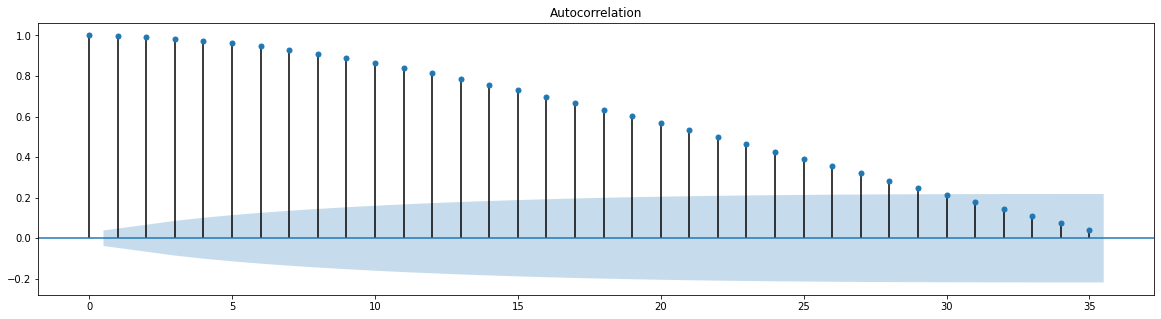

In [21]:
fig, ax = plt.subplots(1, sharex=True, figsize = (20, 5))
plot_acf(X_part, ax=ax)
plt.show()

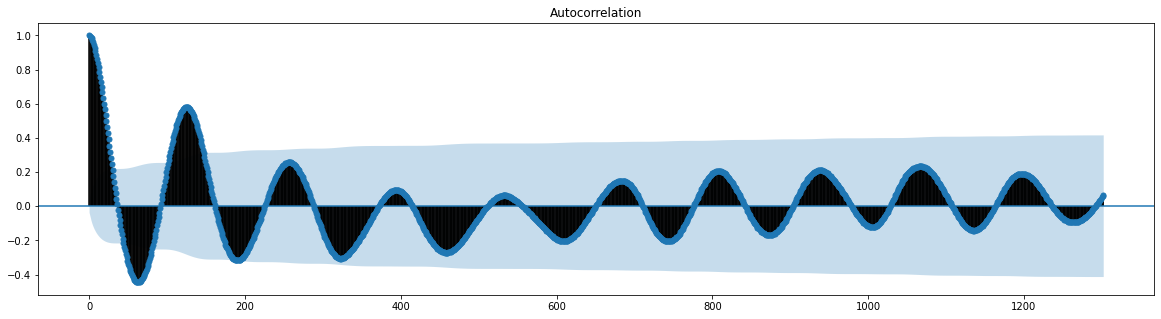

In [22]:
fig, ax = plt.subplots(1, sharex=True, figsize = (20, 5))
plot_acf(X_part, ax=ax, lags=round(len(X_part)/2))
plt.show()

Порядок авторегрессии определим на основе частичной автокорреляции. Изначально принимаем значение p = 3, равным количеству лагов, которые пересекают предел значимости на графике PACF.

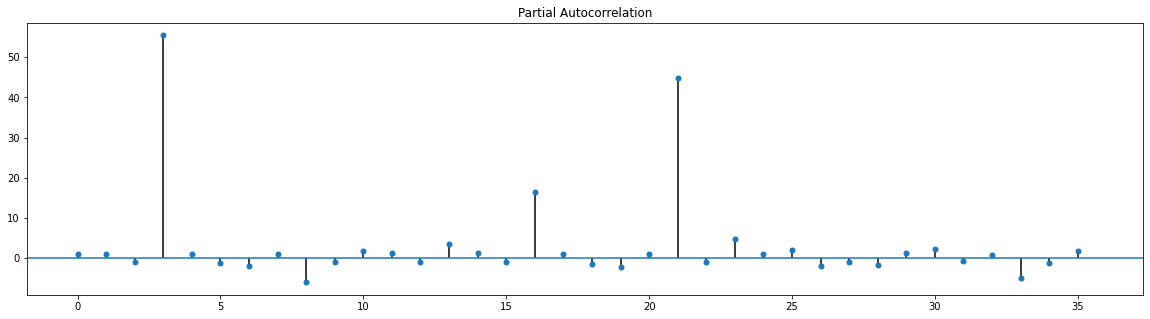

In [23]:
fig, ax = plt.subplots(1, sharex=True, figsize = (20, 5))
plot_pacf(X_part, ax=ax)
plt.show()

Порядок скользящего среднего так же определим как q = 1. Если посмотреть на количество лагов, пересекающих порог на графике Автокорелляционной функции, то можно определить, какая часть прошлых наблюдений будет достаточно значимой, чтобы учитывать ее в будущем. Наблюдения с более высокой корреляцие вносят больший вклад. Этого будет достаточно для прогнозирования будущих значений. 

Таким образом предварительная модель может выглядиь так: AIRMA(3, 0, 1)

При этом, стоит иметь ввиду, что все параметры мы определяли "визуально" на графике. Если обратиться к смысловым значениям этих параметров, то сразу становится понятно, что нужно рассматрвать большое количество предыдущих наблюдений при построении модели. Поэтому реальная модель AIRMA будет включать в себя AR и MA значительно высоких порядков, что делает задачу постороения данной модели сильно сложнея с точки зрения вычислительных ресурсов. 

На мой взгляд, в рамках данной работы можно даже не пытаться найти оптимальные параметры, так как это может занять очень много времени. Для построения прогноза лучше обратиться к другим инструментам.

In [24]:
airma_model = ARIMA(X_part, order=(3,0,1))
model_fit = airma_model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2604
Model:                     ARMA(3, 1)   Log Likelihood               -4797.237
Method:                       css-mle   S.D. of innovations              1.524
Date:                Sat, 21 May 2022   AIC                           9606.473
Time:                        14:36:11   BIC                           9641.662
Sample:                             0   HQIC                          9619.222
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.4762     12.161      6.700      0.000      57.642     105.311
ar.L1.y        1.5370      0.020     75.301      0.000       1.497       1.577
ar.L2.y       -0.3261      0.038     -8.615      0.0

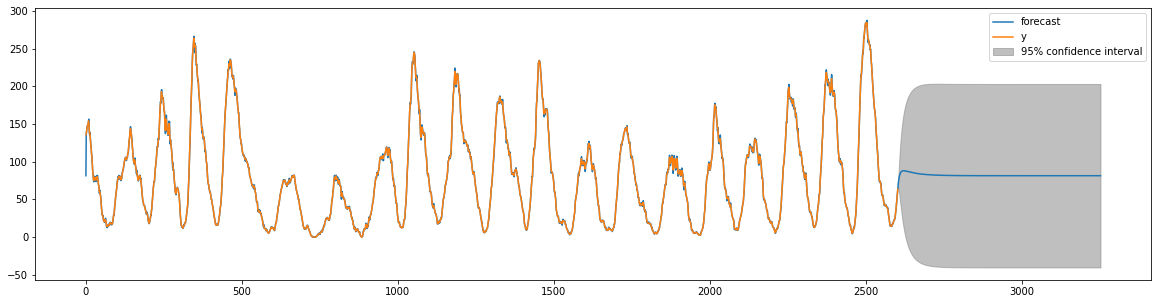

In [26]:
fig, ax = plt.subplots(1, sharex=True, figsize = (20, 5))
model_fit.plot_predict(0, len(X), ax=ax)
plt.show()

Выделим явные периодические составляющие с помощью  методов  вейвлет-анализа. В качестве базового вейвлета используем вейвлет Добеши.

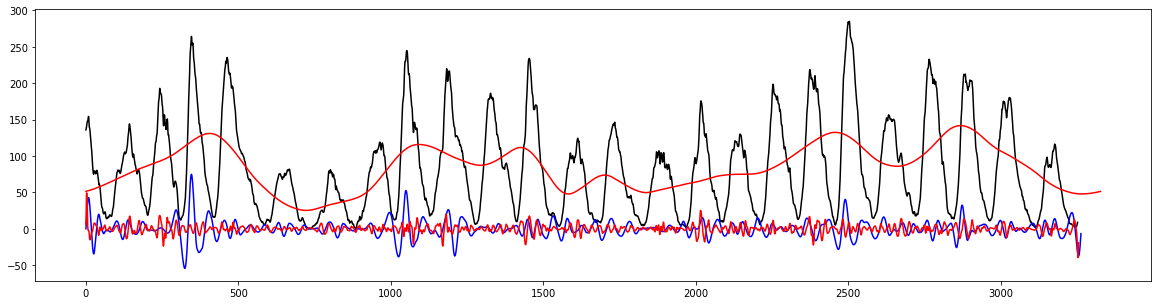

In [238]:
wvlt = pywt.Wavelet('db8')

cA7, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(X, wvlt, mode='periodization', level=7)
Xre = pywt.waverec((None, cD5, None, None, None, None), wvlt, mode='periodization')
Xre2 = pywt.waverec((None, cD4, cD3, None, None), wvlt, mode='periodization')
Xre3 = pywt.waverec((cA7, None, None, None, None, None, None, None), wvlt, mode='periodization')

plt.figure(figsize = (20, 5))
plt.plot(t, X, 'k')
plt.plot(Xre, 'b')
plt.plot(Xre2, 'r')
plt.plot(Xre3)
plt.title("Отдельные компоненты полученные вейвлет-анализом")
plt.show()

In [154]:
def SSA_modes(F, L=3):
  # Первый шаг: Составляем траекторную матрицу
  N = len(F)
  K = N - L + 1
  X = np.column_stack([F[i:i+L] for i in range(0,K)])

  # Второй шаг: SVD
  S = np.dot(X, X.T)
  # Используем реализацию сингуляроного разложения из библиотеки numpy
  U, A, _ = np.linalg.svd(S)
  # Матрица тректорных векторов
  V = np.dot(X.T, U)
  return A, U, V

def SSA_group(A, U, V, N, I, L=3):
  K = N - L + 1
  # Шаг группировки
  V = V.transpose()
  Z = np.dot(U[:, I], V[I, :])
  # Шаг диагонального  усреднения
  G = np.zeros(N)
  Ll = min(L, K)
  Kk = max(L, K)

  gs1 = [1/(k + 1) * sum([Z[m, k - m] for m in range(0, k + 1)]) 
                                  for k in range(0, Ll - 1)]

  gs2 = [1/Ll * sum([Z[m, k - m] for m in range(0, Ll)]) 
                               for k in range(Ll - 1, Kk)]

  gs3 = [1/(N - k) * sum([Z[m, k - m] for m in range(k - Kk + 1, N - Kk + 1)]) 
                                  for k in range(Kk, N)]
  return np.array(gs1 + gs2 + gs3)

def SSA_R(M, A, U, V, N, I, L=3):
  vu = np.linalg.norm(U[-1, I])
  # Ряд весовых коэффициентов
  R = np.sum(U[L-1, I] * U[0:L-1, I], 1)
  R = R / (1 - vu*vu)
  G = SSA_group(A, U, V, N, I, L)
  Q = np.zeros(N + M - 1)
  Q[:N] = G

  for i in range(N, N + M - 1):
    Q[i] = sum([R[-j-1]*Q[i-j-1] for j in range(0, L - 2)])

  return Q

Выделим периодические компоненты из ряда методом SSA. Результат можно увидеть на графке ниже:

In [116]:
L = 500
A, U, V = SSA_modes(X, L)
ts0 =  SSA_group(A, U, V, len(X), [0], L)
ts1 =  SSA_group(A, U, V, len(X), [1], L)
ts2 =  SSA_group(A, U, V, len(X), [2], L)
ts3 =  SSA_group(A, U, V, len(X), [3], L)
ts0123 = SSA_group(A, U, V, len(t), [0, 1, 2, 3], L)
ts01 = SSA_group(A, U, V, len(t), [0, 1], L)
ts12 = SSA_group(A, U, V, len(t), [1, 2], L)
ts23 = SSA_group(A, U, V, len(t), [2, 3], L)

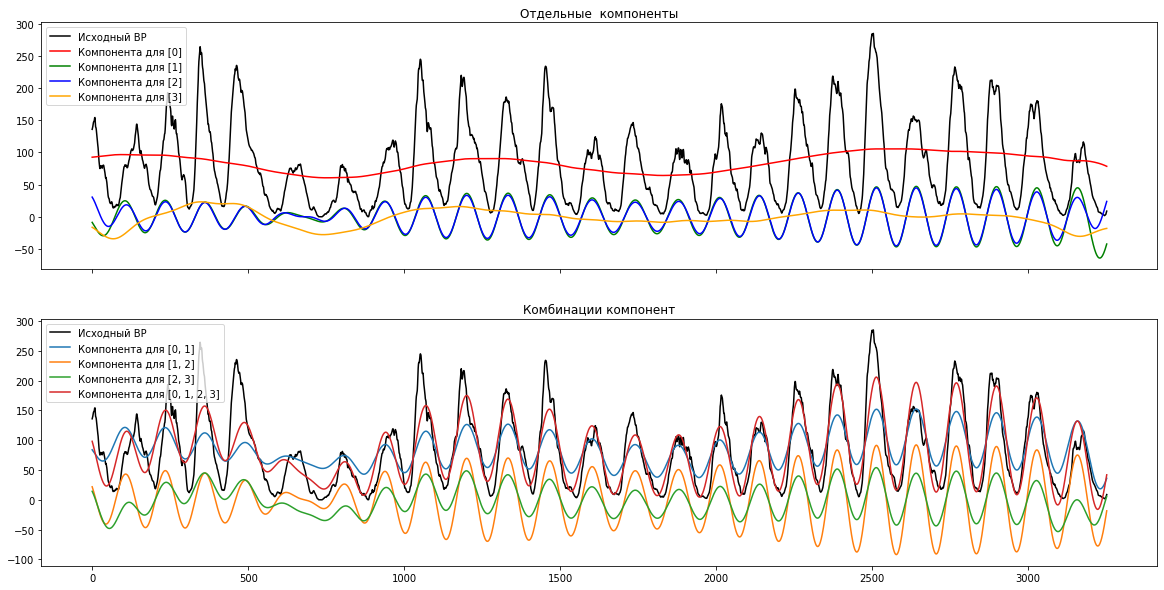

In [124]:
fig, ax = plt.subplots(2, sharex=True, figsize = (20, 10))

ax[0].plot(t, X, 'k', label='Исходный ВР')
ax[0].plot(t, ts0, 'red', label='Компонента для [0]')
ax[0].plot(t, ts1, 'green', label='Компонента для [1]')
ax[0].plot(t, ts2, 'blue', label='Компонента для [2]')
ax[0].plot(t, ts3, 'orange', label='Компонента для [3]')
ax[1].plot(t, X, 'k', label='Исходный ВР')
ax[1].plot(t, ts01, label='Компонента для [0, 1]')
ax[1].plot(t, ts12, label='Компонента для [1, 2]')
ax[1].plot(t, ts23, label='Компонента для [2, 3]')
ax[1].plot(t, ts0123, label='Компонента для [0, 1, 2, 3]')
ax[0].set_title("Отдельные  компоненты методом SSA")
ax[1].set_title("Комбинации компонент методом SSA")
ax[0].legend(loc=2)
ax[1].legend(loc=2)
plt.show()

Построим прогноз ряда  с  помощью  рекурсивного  метода Сингулярного Спектрального Анализа SSA-R. Результат прогноза для данного метода можно увидить на графике:

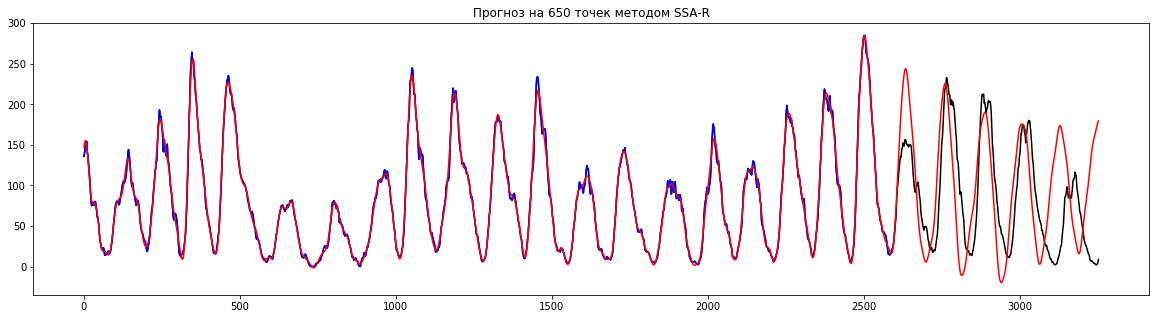

In [177]:
L = 700
M = pred_size

A, U, V = SSA_modes(X_part, L)
tsr = SSA_R(M, A, U, V, len(X_part), [i for i in range(40)], L)

plt.figure(figsize = (20, 5))
plt.plot(t, X, 'k') # исходный ВР
plt.plot(t[:-pred_size+1], X_part, 'b') # урезанный ряд
plt.plot(t, tsr, 'r') # предсказанный ряд
plt.title(f"Прогноз на {pred_size} точек методом SSA-R")
plt.show()

Построим прогноз данных с помощью нейронной сети LSTM на 650 точек. Для этого явно разделим ВР на обучающую и тестовую выборку. Так же отмаштабируем значения до диапазона 0–1, который является диапазоном значений с плавающей запятой, где наибольшая вычеслительная точность. 
Чтобы недопустить утечку информации из тренеровчных данных в тестовые, подберем MinMaxScaler, используя только тренеровчные данные. Данный scaler мы будем применять к тестовым данным перед перед прогнозом.

In [205]:
look_back = 6
threshold = len(X) - pred_size

X_train = X[:-pred_size]
X_test = X[-pred_size-look_back:]

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train.reshape(-1, 1))
X_test = scaler.transform(X_test.reshape(-1, 1))

In [206]:
train_data_gen = TimeseriesGenerator(X_train, 
                                     X_train,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=3)

test_data_gen = TimeseriesGenerator(X_test, 
                                    X_test,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=1)

Для поиска оптимальной модели на основе LSTM, воспользуемся KerasTuner, который на основе функции-сборщика модели будет строить и обучать различные вариатны нейронной сети и сравнивать их между собой по метрике MSE. Модель с наименьшим MSE и будет оптимальной моделью для данного временного ряда.

In [209]:
def build_model(hp):
  model = Sequential()

  model.add(LSTM(hp.Int('input_unit', min_value=35, max_value=50, step=5), 
                 return_sequences=True, 
                 input_shape=(train_data_gen[0][0].shape[1], (train_data_gen[0][0].shape[2]))))
  
  for i in range(hp.Int('n_layers', 1, 3)):
    model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=35,max_value=50,step=5), 
                   return_sequences=True))

  model.add(LSTM(hp.Int('layer_2_neurons', min_value=35, max_value=50, step=5)))
  
  model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)))

  model.add(Dense(train_data_gen[0][1].shape[1], 
                  activation=hp.Choice('dense_activation', values=['relu', 'sigmoid'], default='relu')))
  
  model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])
  return model

In [210]:
!pip install keras_tuner
from keras_tuner import RandomSearch
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial=1,
        directory='final task',
        project_name='LSTM_tuner')

Запустим поиск по заданному выше шаблону для нейронной сети.

In [211]:
tuner.search(
        train_data_gen,
        epochs=10,
        batch_size=10,
        validation_data=test_data_gen)

Trial 2 Complete [00h 03m 12s]
mse: 0.000380133802536875

Best mse So Far: 0.000380133802536875
Total elapsed time: 00h 08m 13s
INFO:tensorflow:Oracle triggered exit


Найденная в результате RandomSearch модель имеет следующий вид:

Results summary
Results in final task/LSTM_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 45
n_layers: 1
lstm_0_units: 40
layer_2_neurons: 45
Dropout_rate: 0.1
dense_activation: sigmoid
lstm_1_units: 45
Score: 0.000380133802536875
Trial summary
Hyperparameters:
input_unit: 35
n_layers: 2
lstm_0_units: 50
layer_2_neurons: 40
Dropout_rate: 0.2
dense_activation: sigmoid
lstm_1_units: 35
Score: 0.0005743927322328091
None


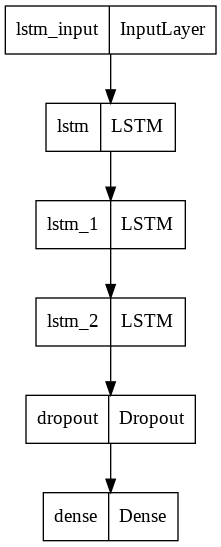

In [212]:
best_model = tuner.get_best_models(num_models=1)[0]
print(tuner.results_summary())
plot_model(best_model, to_file='model.png')

Результат прогноза для данной сети LSTM можно увидить на графике:

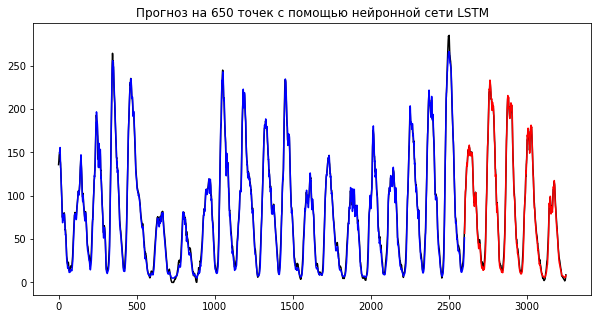

In [214]:
trainPredict = best_model.predict(train_data_gen)
testPredict = best_model.predict(test_data_gen)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

plt.figure(figsize = (10, 5))
plt.plot(X, 'k')
plt.plot(np.r_[look_back:threshold], trainPredict,'b')
plt.plot(np.r_[threshold:F.shape[0]], testPredict, 'r')
plt.title(f"Прогноз на {pred_size} точек с помощью нейронной сети LSTM")
plt.show()